## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [39]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [40]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [41]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [42]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [43]:
df.groupby('user_id')['converted'].mean().mean(), df['converted'].mean()

(0.1195557910965504, 0.11965919355605512)

e. The number of times the `new_page` and `treatment` don't line up.

In [44]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape

(3893, 5)

f. Do any of the rows have missing values?

In [45]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [46]:
df2 = df[
    (((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True)
    | (((df['group'] == 'control') == (df['landing_page'] == 'old_page')) == True)
]

In [47]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [48]:
df2['user_id'].nunique(), df2.shape

(290584, (290585, 5))

b. There is one **user_id** repeated in **df2**.  What is it?

In [49]:
df2[df2.duplicated(subset = 'user_id') == True].iloc[0,0]

773192

c. What is the row information for the repeat **user_id**? 

In [50]:
df2[df2.duplicated(subset = 'user_id') == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [51]:
df2 = df2.drop_duplicates(subset = 'user_id')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [52]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [53]:
control_p = df2.query('group == "control"')['converted'].mean()
control_p

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [54]:
treatment_p = df2.query('group == "treatment"')['converted'].mean()
treatment_p


0.11880806551510564

d. What is the probability that an individual received the new page?

In [55]:
df2.query('landing_page == "new_page"').count()[0] / df2.count()[0]

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

Based on the so far gathered evidence, users were slightly more likely to convert if they landed on the old page as opposed to the new. Without further analysis I can't say if its a significant difference but I can say based on this evidence I would certainly fail to reject the null hypothesis that states the old page leads to an equal or greater proportion of users converting.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \le 0$$

$$H_1: p_{new} - p_{old} \gt 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [56]:
p_null = df2['converted'].mean()
p_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [57]:
p_null

0.11959708724499628

c. What is $n_{new}$?

In [58]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [59]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [60]:
new_page_converted = np.random.binomial(1, p_null, n_new)
    

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [61]:
old_page_converted = np.random.binomial(1, p_null, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [62]:
new_page_converted.mean() - old_page_converted.mean()

-0.0016744227186074878

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [63]:
p_diffs = []
for _ in range(int(1e4)):
    new_mean = np.random.binomial(1, p_null, n_new).mean()
    old_mean = np.random.binomial(1, p_null, n_old).mean()
    p_diffs.append(new_mean - old_mean)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0,0.5,'Count')

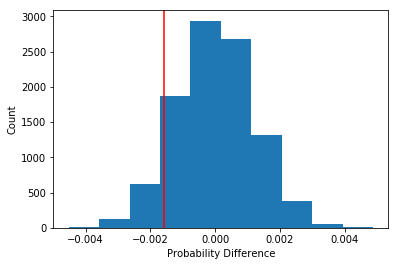

In [64]:
sample_p_diff = treatment_p - control_p
plt.hist(p_diffs);
plt.axvline(sample_p_diff, c='r')
plt.xlabel('Probability Difference')
plt.ylabel('Count')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [65]:
(p_diffs > sample_p_diff).mean()

0.90610000000000002

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This is the p-value for our hypothesis test. It is the probability, assuming the null hypothesis is true, that a random sample of the same dimensions as our data sample could return the same value or greater for $p_{new}$ - $p_{old}$ that we computed.

Our null hypothesis was that the old page was as good or better than the new page. What we found in this data sample was that users on the old page did in fact have a higher probability to convert than users on the new page. 

We would have to run a different hypothesis test if we wanted to see if, based on this data sample, the old page was actually had a better statistically significant conversion rate than the new page. With this p-value, we simply fail to reject our original null hypothesis; that the difference between $p_{new}$ and $p_{old}$ is less than or equal to 0.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [66]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('group == "control"').count()[0]
n_new = df2.query('group == "treatment"').count()[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [67]:
z_score, p_value = sm.stats.proportions_ztest(
[convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score2, p_value2 = sm.stats.proportions_ztest(
[convert_old, convert_new], [n_old, n_new], alternative='two-sided')
print(z_score, p_value)
print(z_score2, p_value2)

1.31092419842 0.905058312759
1.31092419842 0.189883374482


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

I did 2 z tests, a one-sided test and then a two-sided test. The first z-score and p-value are very similar to our original hypothesis test. This is because our original alternative hypothesis was that the new page was better than the old page in terms of conversion rate, which is a one-sided test.

A two-sided test is when our alternative hypothesis is that there is a difference between the old and new pages, i.e., the new page is either better *or worse* than the old page. Even under this more rigorous test though, we would still fail to reject the null hypothesis that there was no difference between the new and old page as the p-value was approximately 0.190, which is greater than our $\alpha$ of 0.05.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [68]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [69]:
log_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
log_result = log_model.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [70]:
log_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        10:57:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  

The p-value for the ab_page variable is 0.190. This is the same as the p-value from the two-sided z-test done earlier, but different from the one-sided z-test as well as the original hypothesis test. 

The reason for this is both the two-sided z-test and the logistic regression model use the null hypothesis that there is no difference between the two pages' conversion rates, while the one-sided z-test and the original hypothesis test was operating under the null hypothesis that the old page has a greater than or the same conversion rate. The difference being that for the original hypothesis test, the old page could be significantly better than the new page, and we would fail to reject the null hypothesis, but the logistic regression model would reject its null hypothesis if that were the case. 

In both cases we would still reject switching to the new landing page, but the null hypotheses are different so the p-values are different.



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Your model can become better at predicting the desired outcome with more inputs that are related to that outcome. 

However, if the added inputs are very related to other inputs, they can cause misleading results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

Here I load the data and check its size and values.

In [71]:
df_c = pd.read_csv('countries.csv')
print(df_c['country'].value_counts())
print(df_c.shape)
df_c.head()


US    203619
UK     72466
CA     14499
Name: country, dtype: int64
(290584, 2)


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Now I join it under the assumption that because it has the exact number of rows as df2, I don't need to worry about any NaNs or anything.

I also made a new dataframe, df3, to use because otherwise I would get an error if I ever ran this cell more than once without running previous cells redefining df2.

In [72]:
df3 = df2.join(df_c.set_index('user_id'), on='user_id')

And then I check just to make sure there are no NaNs.

In [73]:
print(df3.shape)
print(df3.isnull().sum())


(290584, 8)
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
country         0
dtype: int64


And with the dataframes successfully joined I can create dummy columns and fit a logistic regression model using those columns.

In [74]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
log_model2 = sm.Logit(
    df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US']]
)
log_result2 = log_model2.fit()
log_result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 10 Jul 2018   Pseudo R-squ.:               2.323e-05
Time:                        10:57:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

Using Canada as the baseline, neither the UK or the US is found to significantly differ in conversion rate, based on their p-values being above 0.05. Comparing the UK's confidence interval to the US's, they also don't seem to significantly differ from each other either, as they overlap quite a bit.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [75]:
df3['ab_CA'] = df3['ab_page']*df3['CA']
df3['ab_UK'] = df3['ab_page']*df3['UK']
df3['ab_US'] = df3['ab_page']*df3['US']

log_model3 = sm.Logit(
    df3['converted'], df3[[
        'intercept', 'ab_page', 'UK', 'US', 'ab_UK', 'ab_US']]
)
log_result3 = log_model3.fit()
log_result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 10 Jul 2018   Pseudo R-squ.:               3.482e-05
Time:                        10:57:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

Using higher order terms, the coefficients found are no longer as easily interpreted. However in this case, none of the predictors have low enough p-values to be significant so my conclusion is there is no important interaction effect between country and landing page.

<a id='conclusions'></a>
## Conclusions

Overall, I found that I was unable to reject the null hypothesis that the old landing page is as good or better than the new landing page, using conversion rate as the metric. I was also unable to reject the null hypothesis that the old landing page performed significantly different in either direction compared to the new landing page.

Using logistic regression, there was no significant relationship found between the landing page group and if the user converted, or between country of the user and conversion. There was also no interaction effect between country and landing page found, which strengthens the analysis that there is no relationship between the mentioned factors.

In [77]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0